# Spherical harmonic analysis using low-level functions (without SHCoeffs and SHGrid classes)

This tutorial demonstrates how to analyse global data on the sphere using spherical harmonic functions. In contrast to the introductory notebooks that make use of the *pyshtools* classes `SHCoeffs` and `SHGrid`, these examples will instead make use of python and fortran wrapped functions.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pyshtools as pysh

In [2]:
pysh.utils.figstyle(rel_width=0.75)
%config InlineBackend.figure_format = 'retina'  # if you are not using a retina display, comment this line

In this example, we will make use the Earth2014 topography model of Hirt and Rexer (2015) that we read directly from a data respository on the web. This file is in a binary 'bshc' format, that we read using the `datasets` module. We then expand it onto a grid using `MakeGridDH()`:

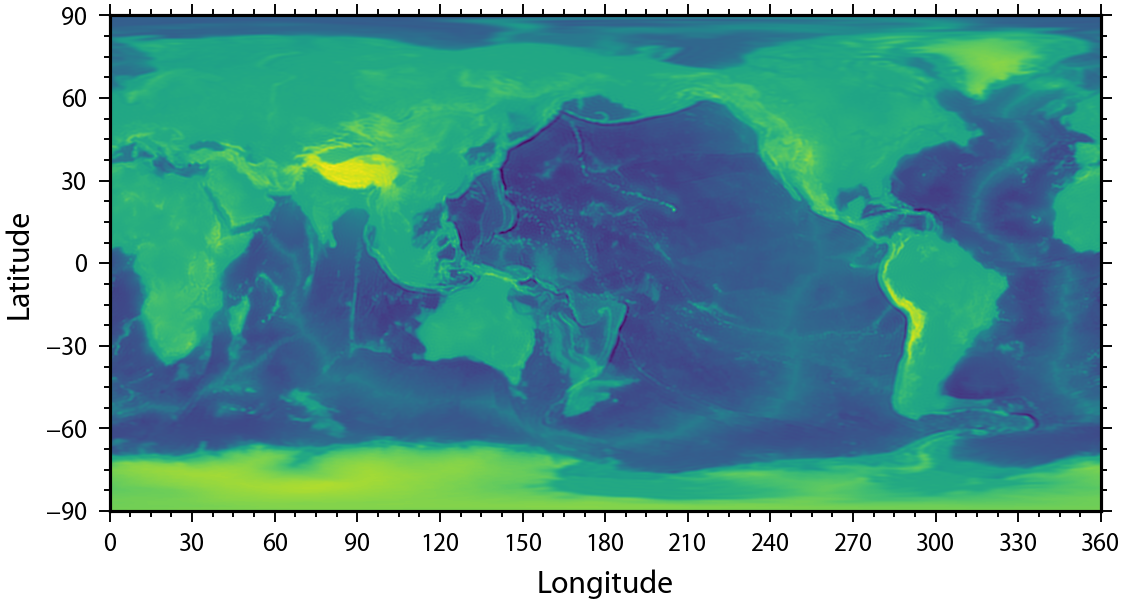

In [3]:
clm = pysh.datasets.Earth.Earth2014.tbi(lmax=300)
topo = pysh.expand.MakeGridDH(clm.coeffs, sampling=2) / 1000.

fig, ax = plt.subplots(1, 1)
ax.imshow(topo, extent=(0, 360, -90, 90))
ax.set(xlabel='Longitude', ylabel='Latitude', yticks=np.arange(-90, 120, 30), xticks=np.arange(0, 390, 30))
ax.minorticks_on()

Using the grid `topo`, we will first demonstrate how to calculate the power spectrum, and second, how to perform simple filtering operations.

## The power spectrum

The power spectrum of a function describes how the variance of the function is distributed as a function of spherical harmonic degree. Concentration of power (or energy) in spherical harmonics with a particular wavelength can give hints about the origin of the feature. First, let's expand the gridded data into spherical harmonics using the function `SHExpandDH()`:

In [4]:
coeffs = pysh.expand.SHExpandDH(topo, sampling=2)

The "power spectrum" can be calculated using different conventions. The default in *pyshtools* is to calculate the total power of all angular orders as a function of spherical harmonic degee, which corresponds to the option `unit='per_l'`. The power per degree l is somewhat equivalent to the power at a given wavenumber magnitude |k| in 2D Fourier analyses. The power spectrum is computed using the function `spectrum()`:

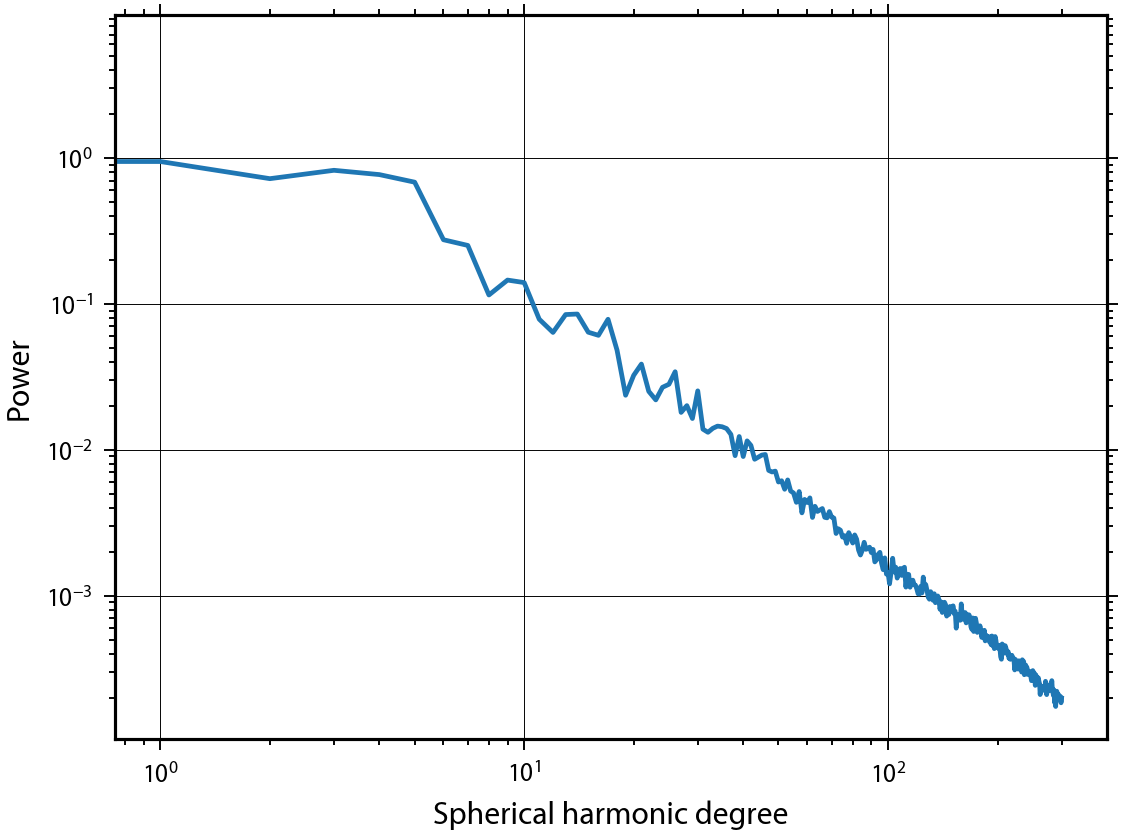

In [5]:
power_per_l = pysh.spectralanalysis.spectrum(coeffs)
degrees = np.arange(coeffs.shape[1])

fig, ax = plt.subplots(1, 1)
ax.plot(degrees, power_per_l)
ax.set(yscale='log', xscale='log', xlabel='Spherical harmonic degree', ylabel='Power')
ax.grid()

The average power per coefficient as a function of spherical harmonic degree can be calculated by setting the parameter `unit` equal to `'per_lm'`. This is simply the power per degree divided by (2l+1), and is analogous to the power per wavenumber $k_x$ and $k_y$ in 2D Fourier analyses.

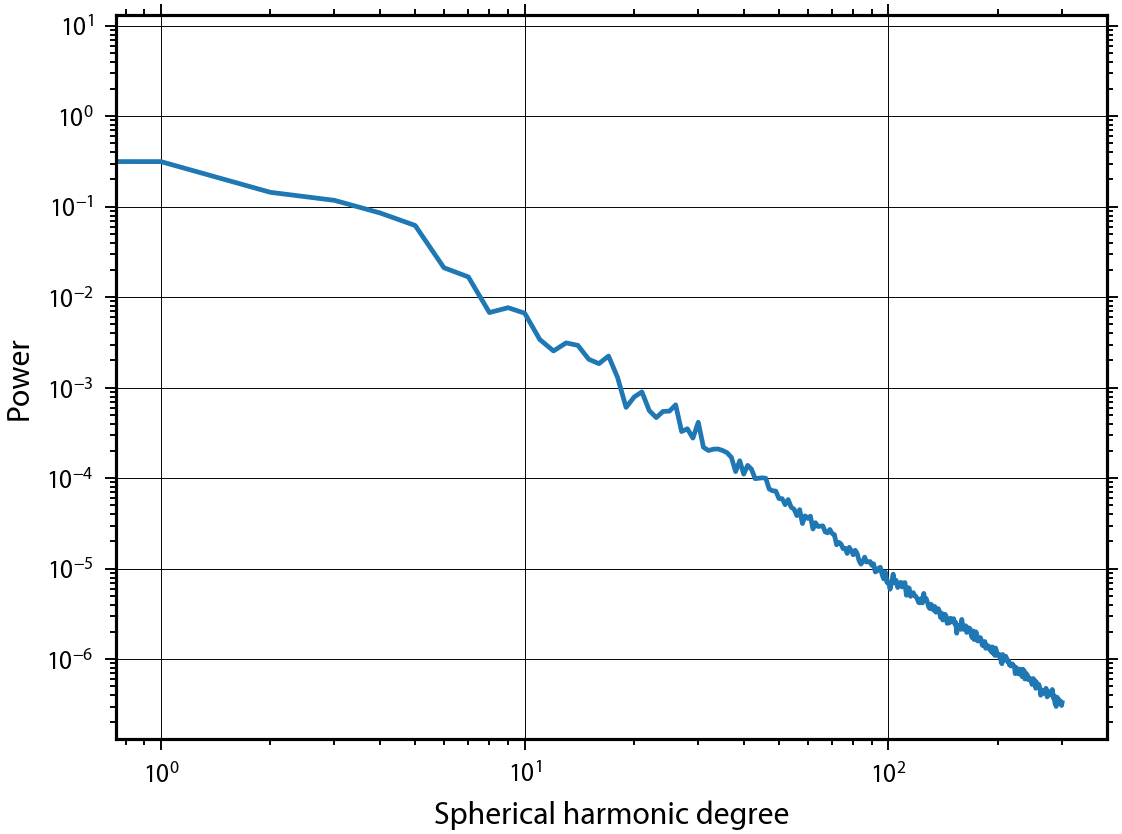

In [6]:
power_per_lm = pysh.spectralanalysis.spectrum(coeffs, unit='per_lm')

fig, ax = plt.subplots(1, 1)
ax.plot(degrees, power_per_lm)
ax.set(xscale='log', yscale='log', xlabel='Spherical harmonic degree', ylabel='Power')
ax.grid()

Finally, the contribution to the total power from all angular orders over an infinitessimal logarithmic degree band `dlog_a(l)` can be calculated by setting `unit='per_dlogl'`. In this case, the contrubution in the band
`dlog_a(l)` is `spectrum(l, 'per_dlogl')*dlog_a(l)`, where `a` is the base, and where `spectrum(l, 'per_dlogl)` is equal to `spectrum(l, 'per_l')*l*log(a)`. This power spectrum is useful to analyse dominant scales.

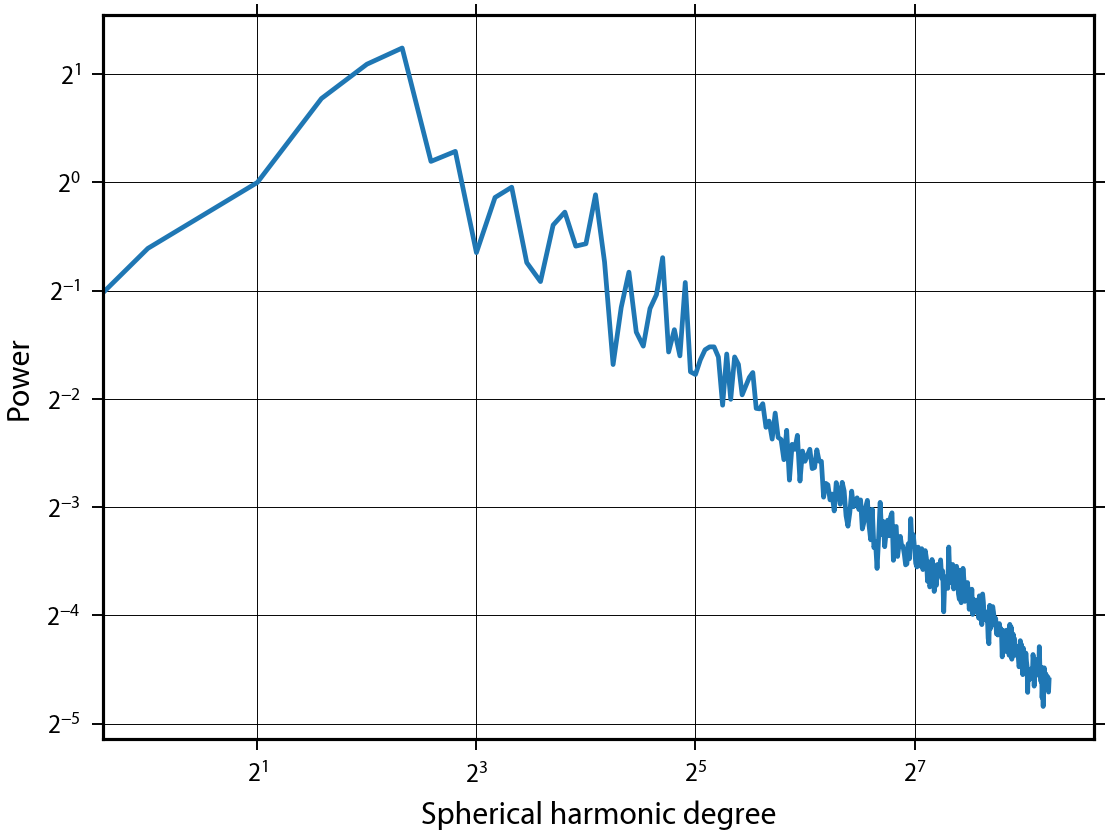

In [7]:
power_per_dlogl = pysh.spectralanalysis.spectrum(coeffs, unit='per_dlogl', base=2.)

fig, ax = plt.subplots(1, 1)
ax.plot(degrees, power_per_dlogl)
ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.set(ylabel='Power', xlabel='Spherical harmonic degree')
ax.grid()

## Simple Filtering

A global dataset can be filtered isotropically by multiplying the spherical harmonic coefficients by a degree-dependent function. We demonstrate this by setting the coefficients greater or equal to degree 8 equal to zero.

In [8]:
coeffs_filtered = coeffs.copy()
lmax = 8
coeffs_filtered[:, lmax:, :] = 0.

topo_filtered = pysh.expand.MakeGridDH(coeffs_filtered, sampling=2)

Next, we bandpass filter the data to retain only spherical harmonic coefficients between degrees 8 and 20.

In [9]:
coeffs_filtered2 = coeffs.copy()
lmin, lmax = 8, 20
coeffs_filtered2[:, :lmin, :] = 0.
coeffs_filtered2[:, lmax:, :] = 0.

topo_filtered2 = pysh.expand.MakeGridDH(coeffs_filtered2, sampling=2)

Finally, let's plot the two filtered data sets:

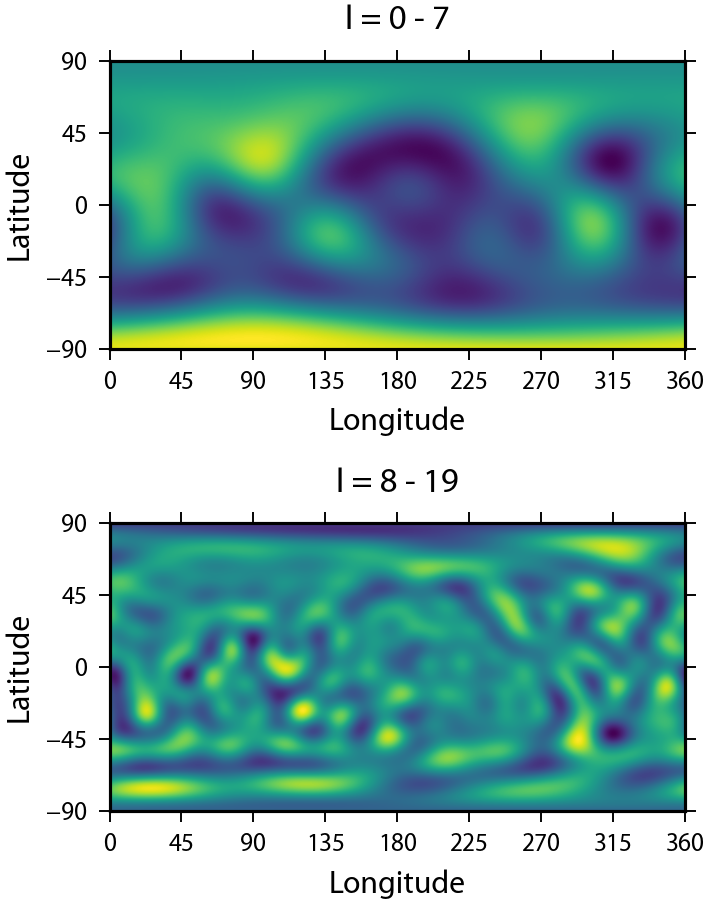

In [10]:
fig, (row1, row2) = plt.subplots(2, 1)
row1.imshow(topo_filtered, extent=(0, 360, -90, 90))
row1.set(xlabel='Longitude', ylabel='Latitude', title='l = 0 - 7', yticks=np.arange(-90,135,45), xticks=np.arange(0,405,45))
row2.imshow(topo_filtered2, extent=(0, 360, -90, 90))
row2.set(xlabel='Longitude', ylabel='Latitude', title='l = 8 - 19', yticks=np.arange(-90,135,45), xticks=np.arange(0,405,45))
fig.tight_layout()